In [52]:
import warnings
warnings.filterwarnings(action='ignore') 

import datetime
import pandas as pd
import numpy as np
import csv
import folium
from folium.plugins import HeatMap 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans    ##  K-means 임포트
from sklearn.metrics import silhouette_score
import scipy as sp
from scipy.cluster.hierarchy import dendrogram, linkage
import statsmodels.formula.api as smf
from dateutil.relativedelta import relativedelta
# import setuptools.dist
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
plt.rc('font',family='D2CodingLigature Nerd Font')
# plt.rcParams['axes.unicode_minus']=False  # '- 표시

## 코로나 바이러스의 영향으로 외국인 관광객은 얼마나 줄었을까?

### 월별 외국인 관광객 통계에 대한 데이터를 전처리하여 시각화까지

In [53]:
## 1번행을 컬럼 이름으로 사용
kto_201901 = pd.read_excel('../../data/kto/kto_201901.xlsx', header=1, usecols='A:G', skipfooter=4)
kto_201901.head()

,국적,관광,상용,공용,유학/연수,기타,계
0,아시아주,765082,10837,1423,14087,125521,916950
1,일본,198805,2233,127,785,4576,206526
2,대만,86393,74,22,180,1285,87954
3,홍콩,34653,59,2,90,1092,35896
4,마카오,2506,2,0,17,45,2570


In [54]:
kto_201901.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   국적      67 non-null     object
 1   관광      67 non-null     int64 
 2   상용      67 non-null     int64 
 3   공용      67 non-null     int64 
 4   유학/연수   67 non-null     int64 
 5   기타      67 non-null     int64 
 6   계       67 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 3.8+ KB


In [55]:
kto_201901.describe().round(2)

,관광,상용,공용,유학/연수,기타,계
count,67.00,67.00,67.00,67.00,67.00,67.00
mean,26396.81,408.21,132.51,477.46,5564.21,32979.19
std,102954.05,1416.04,474.41,2009.48,17209.44,122821.37
min,0.00,0.00,0.00,0.00,16.00,54.00
25%,505.00,14.50,2.50,17.50,260.00,927.00
50%,1304.00,45.00,14.00,43.00,912.00,2695.00
75%,8365.00,176.50,38.00,182.00,2824.50,14905.50
max,765082.00,10837.00,2657.00,14087.00,125521.00,916950.00


## 데이터 전처리

In [56]:
condition=(kto_201901['관광']==0)|(kto_201901['상용']==0)|(kto_201901['공용']==0)|(kto_201901['유학/연수']==0)
kto_201901[condition]

,국적,관광,상용,공용,유학/연수,기타,계
4,마카오,2506,2,0,17,45,2570
20,이스라엘,727,12,0,9,57,805
22,우즈베키스탄,1958,561,0,407,2828,5754
38,스위스,613,18,0,19,97,747
45,그리스,481,17,4,0,273,775
46,포르투갈,416,14,0,13,121,564
51,크로아티아,226,12,0,3,250,491
54,폴란드,713,10,0,27,574,1324
59,대양주 기타,555,3,4,0,52,614
63,기타대륙,33,4,0,1,16,54


In [57]:
## 기준년월 컬럼 생성
kto_201901['기준년월']='2019-01'
kto_201901.head()

,국적,관광,상용,공용,유학/연수,기타,계,기준년월
0,아시아주,765082,10837,1423,14087,125521,916950,2019-01
1,일본,198805,2233,127,785,4576,206526,2019-01
2,대만,86393,74,22,180,1285,87954,2019-01
3,홍콩,34653,59,2,90,1092,35896,2019-01
4,마카오,2506,2,0,17,45,2570,2019-01


In [58]:
## unique() 함수 활용하여 국가 알아보기
kto_201901['국적'].unique()

array(['아시아주', '일본', '대만', '홍콩', '마카오', '태국', '말레이시아', '필리핀', '인도네시아',
       '싱가포르', '미얀마', '베트남', '인도', '스리랑카', '파키스탄', '방글라데시', '캄보디아', '몽골',
       '중국', '이란', '이스라엘', '터키', '우즈베키스탄', '카자흐스탄', 'GCC', '아시아 기타', '미주',
       '미국', '캐나다', '멕시코', '브라질', '미주 기타', '구주', '영국', '독일', '프랑스',
       '네덜란드', '스웨덴', '스위스', '이탈리아', '덴마크', '노르웨이', '벨기에', '오스트리아', '스페인',
       '그리스', '포르투갈', '핀란드', '아일랜드', '우크라이나', '러시아', '크로아티아', '루마니아',
       '불가리아', '폴란드', '구주 기타', '대양주', '오스트레일리아', '뉴질랜드', '대양주 기타',
       '아프리카주', '남아프리카공화국', '아프리카 기타', '기타대륙', '국적미상', '교포소계', '교포'],
      dtype=object)

In [59]:
# 대륙 목록 만들기 
continents_list = ['아시아주', '미주', '구주', '대양주', '아프리카주', '기타대륙', '교포소계']
continents_list

['아시아주', '미주', '구주', '대양주', '아프리카주', '기타대륙', '교포소계']

In [60]:
## 데이터에서 대륙 목록에 해당하는 값 제외
condition = (kto_201901['국적'].isin(continents_list)==False)
kto_201901_country = kto_201901[condition]
kto_201901_country['국적'].unique()

array(['일본', '대만', '홍콩', '마카오', '태국', '말레이시아', '필리핀', '인도네시아', '싱가포르',
       '미얀마', '베트남', '인도', '스리랑카', '파키스탄', '방글라데시', '캄보디아', '몽골', '중국',
       '이란', '이스라엘', '터키', '우즈베키스탄', '카자흐스탄', 'GCC', '아시아 기타', '미국',
       '캐나다', '멕시코', '브라질', '미주 기타', '영국', '독일', '프랑스', '네덜란드', '스웨덴',
       '스위스', '이탈리아', '덴마크', '노르웨이', '벨기에', '오스트리아', '스페인', '그리스', '포르투갈',
       '핀란드', '아일랜드', '우크라이나', '러시아', '크로아티아', '루마니아', '불가리아', '폴란드',
       '구주 기타', '오스트레일리아', '뉴질랜드', '대양주 기타', '남아프리카공화국', '아프리카 기타',
       '국적미상', '교포'], dtype=object)

In [61]:
kto_201901_country

,국적,관광,상용,공용,유학/연수,기타,계,기준년월
1,일본,198805,2233,127,785,4576,206526,2019-01
2,대만,86393,74,22,180,1285,87954,2019-01
3,홍콩,34653,59,2,90,1092,35896,2019-01
4,마카오,2506,2,0,17,45,2570,2019-01
5,태국,34004,37,199,96,6998,41334,2019-01
6,말레이시아,19043,95,7,99,2821,22065,2019-01
7,필리핀,14279,211,161,184,15638,30473,2019-01
8,인도네시아,14183,136,38,187,4298,18842,2019-01
9,싱가포르,8372,94,8,48,1333,9855,2019-01
10,미얀마,1304,10,31,67,3877,5289,2019-01


In [62]:
## index 재설정
kto_201901_country_newindex = kto_201901_country.reset_index(drop=True)
kto_201901_country_newindex.head()

,국적,관광,상용,공용,유학/연수,기타,계,기준년월
0,일본,198805,2233,127,785,4576,206526,2019-01
1,대만,86393,74,22,180,1285,87954,2019-01
2,홍콩,34653,59,2,90,1092,35896,2019-01
3,마카오,2506,2,0,17,45,2570,2019-01
4,태국,34004,37,199,96,6998,41334,2019-01


In [63]:
# 대륙 컬럼값 만들기
continents = ['아시아']*25 + ['아메리카']*5 + ['유럽']*23 + ['오세아니아']*3 + ['아프리카']*2 + ['기타대륙'] + ['교포']
print(continents)

['아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아시아', '아메리카', '아메리카', '아메리카', '아메리카', '아메리카', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '유럽', '오세아니아', '오세아니아', '오세아니아', '아프리카', '아프리카', '기타대륙', '교포']


In [64]:
## 대륙 컬럼 생성
kto_201901_country_newindex['대륙'] = continents
kto_201901_country_newindex.head()

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙
0,일본,198805,2233,127,785,4576,206526,2019-01,아시아
1,대만,86393,74,22,180,1285,87954,2019-01,아시아
2,홍콩,34653,59,2,90,1092,35896,2019-01,아시아
3,마카오,2506,2,0,17,45,2570,2019-01,아시아
4,태국,34004,37,199,96,6998,41334,2019-01,아시아


In [65]:
# 관광객비율(%) 컬럼 생성 
kto_201901_country_newindex['관광객비율(%)'] = round( kto_201901_country_newindex['관광'] / kto_201901_country_newindex['계'] *100, 1)
kto_201901_country_newindex.head()

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%)
0,일본,198805,2233,127,785,4576,206526,2019-01,아시아,96.3
1,대만,86393,74,22,180,1285,87954,2019-01,아시아,98.2
2,홍콩,34653,59,2,90,1092,35896,2019-01,아시아,96.5
3,마카오,2506,2,0,17,45,2570,2019-01,아시아,97.5
4,태국,34004,37,199,96,6998,41334,2019-01,아시아,82.3


In [66]:
## 관광객비율(%)가 가장 높은 국가 확인
kto_201901_country_newindex.sort_values(by='관광객비율(%)', ascending=False)

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%)
1,대만,86393,74,22,180,1285,87954,2019-01,아시아,98.2
3,마카오,2506,2,0,17,45,2570,2019-01,아시아,97.5
2,홍콩,34653,59,2,90,1092,35896,2019-01,아시아,96.5
0,일본,198805,2233,127,785,4576,206526,2019-01,아시아,96.3
55,대양주 기타,555,3,4,0,52,614,2019-01,오세아니아,90.4
19,이스라엘,727,12,0,9,57,805,2019-01,아시아,90.3
53,오스트레일리아,12795,93,17,34,1346,14285,2019-01,오세아니아,89.6
23,GCC,1550,37,14,72,103,1776,2019-01,아시아,87.3
5,말레이시아,19043,95,7,99,2821,22065,2019-01,아시아,86.3
34,스웨덴,844,29,6,18,85,982,2019-01,유럽,85.9


In [67]:
kto_201901_country_newindex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   국적        60 non-null     object 
 1   관광        60 non-null     int64  
 2   상용        60 non-null     int64  
 3   공용        60 non-null     int64  
 4   유학/연수     60 non-null     int64  
 5   기타        60 non-null     int64  
 6   계         60 non-null     int64  
 7   기준년월      60 non-null     object 
 8   대륙        60 non-null     object 
 9   관광객비율(%)  60 non-null     float64
dtypes: float64(1), int64(6), object(3)
memory usage: 4.8+ KB


In [68]:
## 각 대륙을 기준으로 관광객비율(%)의 평균을 내림차순으로 출력
kto_201901_country_newindex.groupby('대륙')[['관광객비율(%)']].mean().sort_values(by='관광객비율(%)', ascending=False)

,관광객비율(%)
대륙,
오세아니아,84.833333
아메리카,68.200000
유럽,63.826087
기타대륙,61.100000
아시아,59.624000
아프리카,32.700000
교포,0.000000


In [69]:
# 중국 국적만 필터링 
kto_201901_country_newindex[kto_201901_country_newindex['국적'] == '중국']

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%)
17,중국,320113,2993,138,8793,60777,392814,2019-01,아시아,81.5


In [70]:
# 유학/연수 인원이 1000명 넘는 데이터만 필터링
kto_201901_country_newindex[kto_201901_country_newindex['유학/연수'] > 1000]

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%)
10,베트남,10739,763,110,1667,6904,20183,2019-01,아시아,53.2
17,중국,320113,2993,138,8793,60777,392814,2019-01,아시아,81.5


In [71]:
# 2019년 1월, 우리나라 방문한 전체 외국인 관광객 숫자
tourist_sum = kto_201901_country_newindex['관광'].sum()
tourist_sum

np.int64(884293)

In [72]:
# 전체관광비율(%) 컬럼 생성
kto_201901_country_newindex['전체관광객비율(%)'] = round(kto_201901_country_newindex['관광'] /tourist_sum * 100, 1)
kto_201901_country_newindex.sort_values(by='전체관광객비율(%)', ascending=False).head()

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%),전체관광객비율(%)
17,중국,320113,2993,138,8793,60777,392814,2019-01,아시아,81.5,36.2
0,일본,198805,2233,127,785,4576,206526,2019-01,아시아,96.3,22.5
1,대만,86393,74,22,180,1285,87954,2019-01,아시아,98.2,9.8
25,미국,42989,418,2578,229,16523,62737,2019-01,아메리카,68.5,4.9
2,홍콩,34653,59,2,90,1092,35896,2019-01,아시아,96.5,3.9


In [74]:
########## exam

m1 = 1 

# zfill() 함수 이용 (0을 포함한 두 자리로 출력하기)
print(str(m1).zfill(2))
print(str(m1).zfill(3))
print(str(m1).zfill(4))
print()

m2 =str(m1).zfill(2)
print('{}{}'.format(2020, m2))
print(f'2020{m2}')
print()

for yy in range(2010, 2020+1):
    for m3 in range(1, 12+1):
        m_str = str(m3).zfill(2)
        yymm = '{}{}'.format(yy, m_str)
        print(yymm)

01
001
0001

202001
202001

201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012
201101
201102
201103
201104
201105
201106
201107
201108
201109
201110
201111
201112
201201
201202
201203
201204
201205
201206
201207
201208
201209
201210
201211
201212
201301
201302
201303
201304
201305
201306
201307
201308
201309
201310
201311
201312
201401
201402
201403
201404
201405
201406
201407
201408
201409
201410
201411
201412
201501
201502
201503
201504
201505
201506
201507
201508
201509
201510
201511
201512
201601
201602
201603
201604
201605
201606
201607
201608
201609
201610
201611
201612
201701
201702
201703
201704
201705
201706
201707
201708
201709
201710
201711
201712
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912
202001
202002
202003
202004
202005
202006
202007
202008
202009
202010
202011
202012


## 데이터 전처리 과정을 사용자 정의 함수로 만들기
create_kto_data 사용자 정의 함수 만들기

In [84]:
def create_kto_data(yy, mm): 
    # 1. Excel 파일 경로 지정하고 파일 불러오기
    file_path = '../../data/kto/kto_{}{}.xlsx'.format(yy, mm)
    df = pd.read_excel(file_path, header=1, skipfooter=4, usecols='A:G')

    # 2. "기준년월" 컬럼 추가 
    df['기준년월'] = '{}-{}'.format(yy, mm) 
    
    # 3. "국적" 컬럼에서 대륙 제거하고 국가만 남기기 
    ignore_list = ['아시아주', '미주', '구주', '대양주', '아프리카주', '기타대륙', '교포소계'] # 제거할 대륙명
    condition = (df['국적'].isin(ignore_list) == False) 
    df_country = df[condition].reset_index(drop=True) 
    
    # 4. "대륙" 컬럼 추가 
    continents = ['아시아']*25 + ['아메리카']*5 + ['유럽']*23 + ['대양주']*3 + ['아프리카']*2 + ['기타대륙'] + ['교포']    # 대륙 컬럼 생성을 위한 목록 만들기 
    df_country['대륙'] = continents 
    
    # 5. 국가별 "관광객비율(%)" 컬럼 추가
    df_country['관광객비율(%)'] = round(df_country['관광'] / df_country['계'] * 100, 1) 
                       
    # 6. "전체비율(%)" 컬럼 추가
    tourist_sum = sum(df_country['관광'])
    df_country['전체관광객비율(%)'] = round(df_country['관광'] / tourist_sum * 100, 1)

    return(df_country)

In [87]:
temp = create_kto_data('2010', '01')
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   국적          60 non-null     object 
 1   관광          60 non-null     int64  
 2   상용          60 non-null     int64  
 3   공용          60 non-null     int64  
 4   유학/연수       60 non-null     int64  
 5   기타          60 non-null     int64  
 6   계           60 non-null     int64  
 7   기준년월        60 non-null     object 
 8   대륙          60 non-null     object 
 9   관광객비율(%)    60 non-null     float64
 10  전체관광객비율(%)  60 non-null     float64
dtypes: float64(2), int64(6), object(3)
memory usage: 5.3+ KB


In [91]:
# 통합 데이터를 저장할 비어있는 데이터프레임 타입 변수 생성
df =  pd.DataFrame()

for yy in range(2010, 2020+1):
    for mm in range(1, 12+1):    # try 이하 구문을 12번 실행         
        try:
            # create_kto_data 함수로 Excel 데이터를 temp 에 불러오기 
            temp = create_kto_data(str(yy), str(mm).zfill(2))
            # temp 로 불러온 데이터를 df 에 추가하기 
            df = pd.concat([df, temp])
        
        except:     # 만약 try 구문에서 에러가 발생하면 except 이후를 실행 
            pass

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 0 to 59
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   국적          7500 non-null   object 
 1   관광          7500 non-null   int64  
 2   상용          7500 non-null   int64  
 3   공용          7500 non-null   int64  
 4   유학/연수       7500 non-null   int64  
 5   기타          7500 non-null   int64  
 6   계           7500 non-null   int64  
 7   기준년월        7500 non-null   object 
 8   대륙          7500 non-null   object 
 9   관광객비율(%)    7500 non-null   float64
 10  전체관광객비율(%)  7500 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 703.1+ KB


## 통합된 데이터를 엑셀파일로 내보내기

In [93]:
df.to_excel('../../data/kto/kto_total.xlsx', index = False)

## 국적별 필터링된 데이터를 엑셀파일로 내보내기

In [94]:
# 국가 리스트 만들기
country_list = df['국적'].unique()
country_list

array(['일본', '대만', '홍콩', '마카오', '태국', '말레이시아', '필리핀', '인도네시아', '싱가포르',
       '미얀마', '베트남', '인도', '스리랑카', '파키스탄', '방글라데시', '캄보디아', '몽골', '중국',
       '이란', '이스라엘', '터키', '우즈베키스탄', '카자흐스탄', 'GCC', '아시아 기타', '미국',
       '캐나다', '멕시코', '브라질', '미주 기타', '영국', '독일', '프랑스', '네덜란드', '스웨덴',
       '스위스', '이탈리아', '덴마크', '노르웨이', '벨기에', '오스트리아', '스페인', '그리스', '포르투갈',
       '핀란드', '아일랜드', '우크라이나', '러시아', '크로아티아', '루마니아', '불가리아', '폴란드',
       '구주 기타', '오스트레일리아', '뉴질랜드', '대양주 기타', '남아프리카공화국', '아프리카 기타',
       '국적미상', '교포'], dtype=object)

In [ ]:
# 국적별 관광객 데이터 엑셀 파일을 생성

for country in country_list: 
    df_filter=df[df['국적']==country]   ## 국적으로 필터링
    
    file_path = '../../data/kto/국적별 관광객 데이터_{}.xlsx'.format(country)
    df_filter.to_excel(file_path, index = False) 

## 시각화

In [97]:
df = pd.read_excel('../../data/kto/kto_total.xlsx')
df.head(2)

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%),전체관광객비율(%)
0,일본,202825,1750,89,549,3971,209184,2010-01,아시아,97.0,50.6
1,대만,35788,41,17,37,516,36399,2010-01,아시아,98.3,8.9


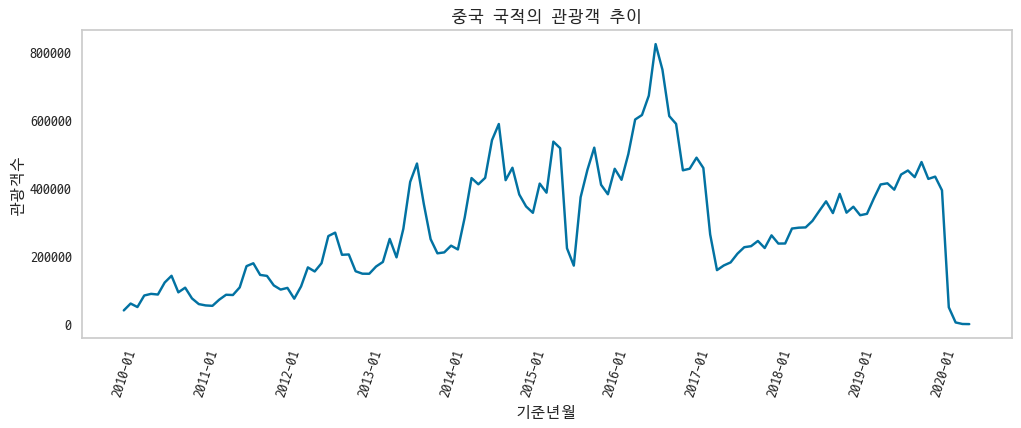

In [99]:
condition = (df['국적'] == '중국')
df_filter = df[condition]

plt.figure(figsize = (12, 4))
plt.plot(df_filter['기준년월'], df_filter['관광'])

plt.grid(False)
plt.title('중국 국적의 관광객 추이')
plt.xlabel('기준년월')
plt.ylabel('관광객수')

plt.xticks(['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', '2017-01',
                                         '2018-01', '2019-01', '2020-01']   ,rotation=72, fontsize=10)
plt.show()

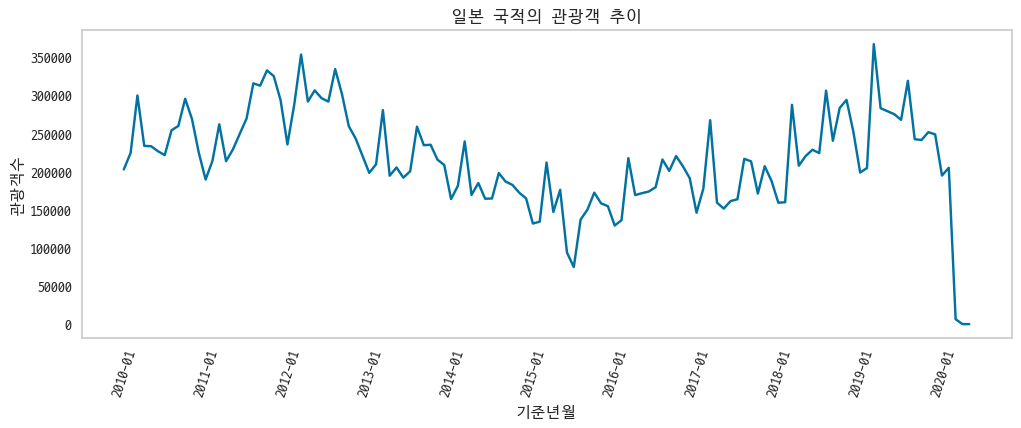

In [100]:
condition = (df['국적'] == '일본')
df_filter = df[condition]

plt.figure(figsize = (12, 4))
plt.plot(df_filter['기준년월'], df_filter['관광'])

plt.grid(False)
plt.title('일본 국적의 관광객 추이')
plt.xlabel('기준년월')
plt.ylabel('관광객수')

plt.xticks(['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', '2017-01',
                                         '2018-01', '2019-01', '2020-01']   ,rotation=72, fontsize=10)
plt.show()

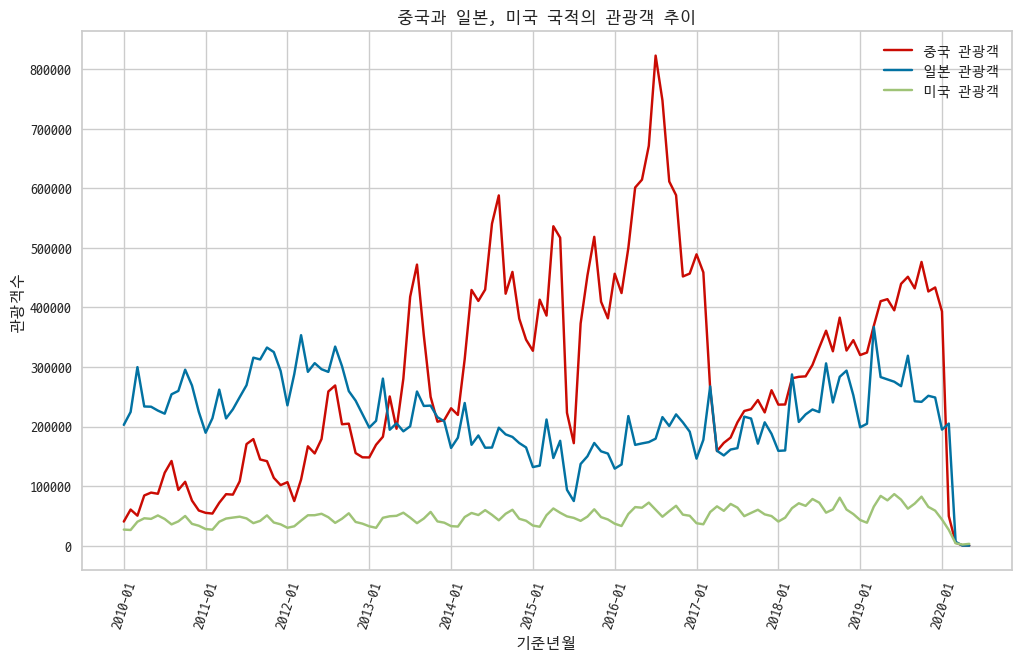

In [101]:
df_filter1 = df[df['국적'] == '중국']
df_filter2 = df[df['국적'] == '일본']
df_filter3 = df[df['국적'] == '미국']

plt.figure(figsize = (12, 7))
plt.plot(df_filter1['기준년월'], df_filter1['관광'], c='r', label = '중국 관광객')
plt.plot(df_filter2['기준년월'], df_filter2['관광'], c='b', label = '일본 관광객')
plt.plot(df_filter3['기준년월'], df_filter3['관광'], c='g', label = '미국 관광객')

plt.title('중국과 일본, 미국 국적의 관광객 추이')
plt.xlabel('기준년월')
plt.ylabel('관광객수')
plt.legend()

plt.xticks(['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', '2017-01',
                                         '2018-01', '2019-01', '2020-01']   ,rotation=72, fontsize=10)
plt.yticks(range(0,800001,100000))
plt.show()

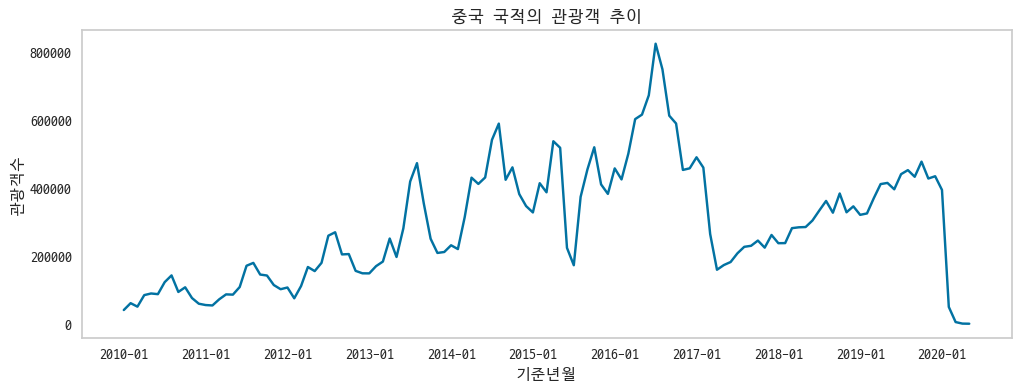

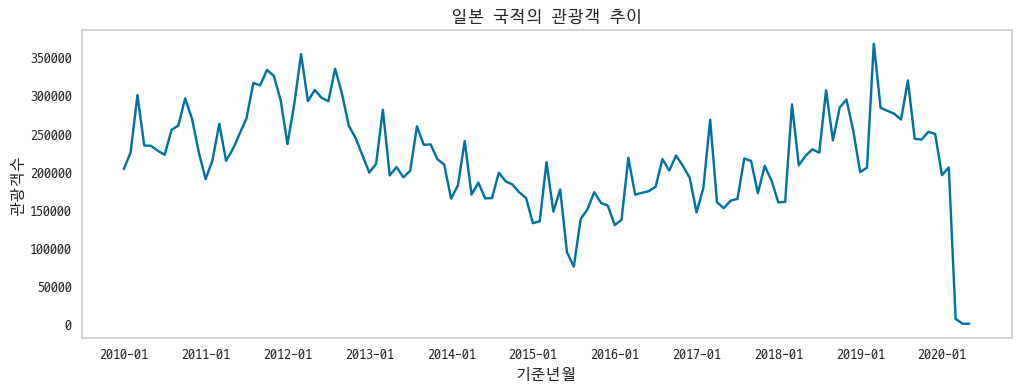

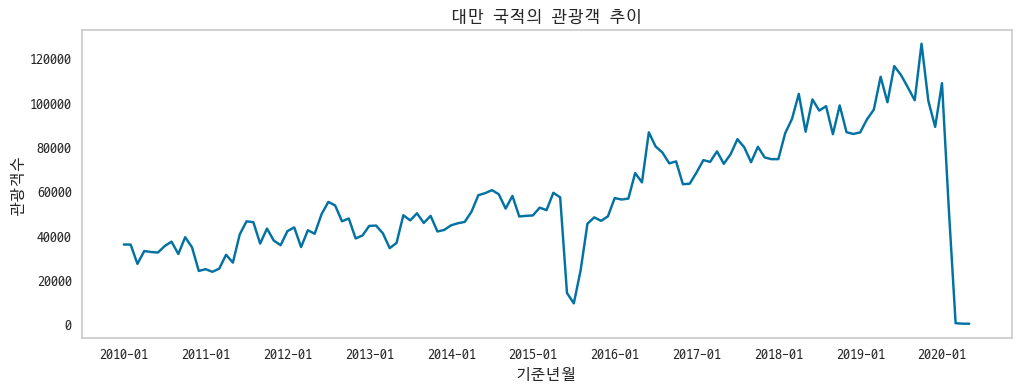

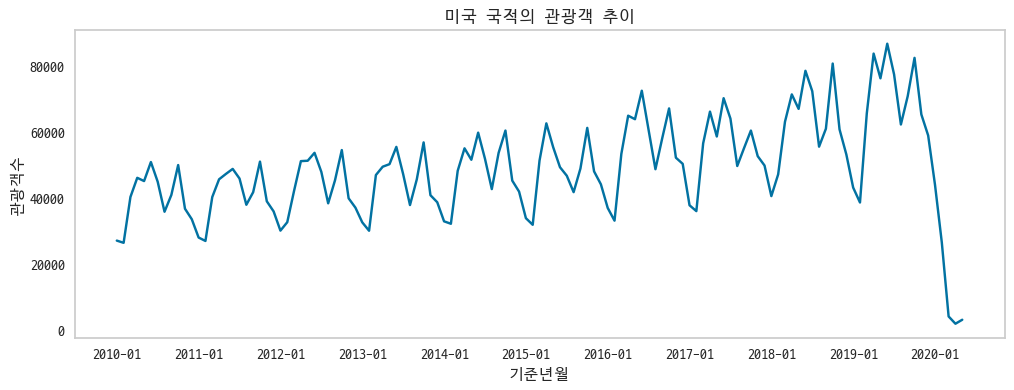

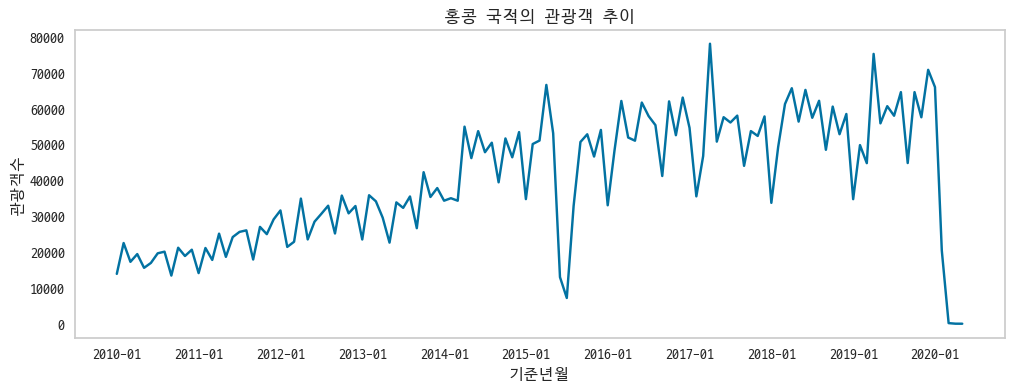

In [102]:
country_list = ['중국', '일본', '대만', '미국', '홍콩']

for country in country_list: 
    df_filter = df[df['국적'] == country]
    
    plt.figure(figsize = (12, 4))
    plt.plot(df_filter['기준년월'], df_filter['관광'])

    plt.grid(False)
    plt.title('{} 국적의 관광객 추이'.format(country))
    plt.xlabel('기준년월')
    plt.ylabel('관광객수')
    plt.xticks(['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', 
                                                             '2017-01', '2018-01', '2019-01', '2020-01'])

    plt.show()

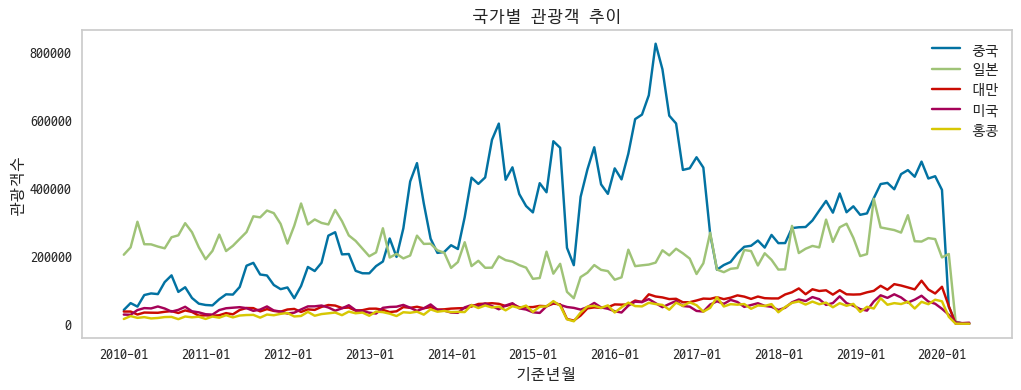

In [103]:
l_country = ['중국', '일본', '대만', '미국', '홍콩']

plt.figure(figsize = (12, 4))

for i_country in l_country: 
    df_filter = df[df['국적'] == i_country]
   
    plt.plot(df_filter['기준년월'], df_filter['관광'], label =i_country )
    plt.title('국가별 관광객 추이')


plt.grid(False)
plt.xlabel('기준년월')
plt.ylabel('관광객수')
plt.xticks(['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', 
            '2016-01', '2017-01', '2018-01', '2019-01', '2020-01'])
plt.legend()
plt.show()

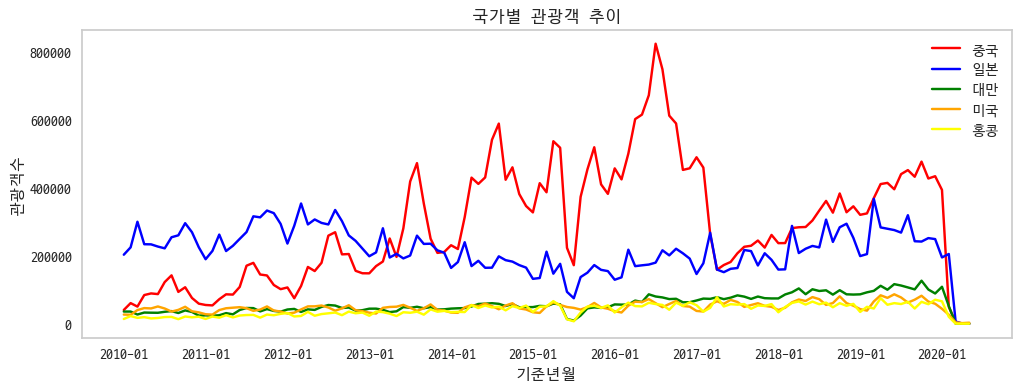

In [104]:
l_country = ['중국', '일본', '대만', '미국', '홍콩']
c = ['red', 'blue', 'green', 'orange', 'yellow']

plt.figure(figsize = (12, 4))

for i_country, c1 in zip(l_country, c): 
    df_filter = df[df['국적'] == i_country]
   
    plt.plot(df_filter['기준년월'], df_filter['관광'], label =i_country, color=c1 )
    plt.title('국가별 관광객 추이')


plt.grid(False)
plt.xlabel('기준년월')
plt.ylabel('관광객수')
plt.xticks(['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', 
            '2016-01', '2017-01', '2018-01', '2019-01', '2020-01'])
plt.legend()
plt.show()